# routing

base routing:
+ method to find the least cost path from one cell to a target cell or multiple targets
+ method to create cost accumulation raster from one or multiple sources (also returns raster of which source was the closest)

add conditions:
+ be able to provide additional roughness raster (slope) to combine with the distance between cells (1,1.414)
+ be able to provide wall cells (e.g slope > 14.1 degrees)
+ be able to provide conditions such as can't go up in elevation

add numba njit

https://numba.discourse.group/t/dijkstra-on-grid/1483/4.   
See priority queue alternative: https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm  
If not fast enough add heuristic for A*?

In [154]:
import numpy as np
from numba import njit
from heapq import heappop, heappush

@njit
def _dijkstra_shortest_path(grid, source, targets, roughness=None, walls=None):
    # targets is list of one or more nodes
    rows, cols = grid.shape
    visited = np.full((rows, cols), fill_value=False, dtype=np.bool)
    distance = np.full((rows, cols), fill_value=99999999, dtype=np.float64)
    distance[start] = 0
    predecessors = {}
    pq = [(0.0, source)]
    closest_target = None

    while pq:
        dist, current = heappop(pq)
        if current in targets:
            closest_target = current
            break
        if visited[current]:
            continue
        visited[current] = True
        cx, cy = current

        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                nx, ny = cx + dx, cy + dy
                if 0 <= nx < rows and 0 <= ny < cols and not visited[(nx, ny)]:
                    cost = 1 if dx == 0 or dy == 0 else 1.414
                    
                    if roughness is not None:
                        cost *= (1 + roughness[nx, ny])  # Modify cost based on roughness

                    if walls is not None:
                        if walls[nx, ny]:
                            continue
                            
                    new_dist = dist + cost
                    if new_dist < distance[(nx, ny)]:
                        distance[(nx, ny)] = new_dist
                        predecessors[(nx, ny)] = current
                        heappush(pq, (new_dist, (nx, ny)))
                        
    if closest_target is not None:
        path = []
        current = closest_target
        while current != start:
            path.append(current)
            current = predecessors[current]
    
        path.append(start)
        path.reverse()
        return distance, path
    else:
        return distance, None

In [183]:
@njit
def _dijkstra_accumulation_multiple_sources(grid, sources, roughness=None, walls=None):
    # targets is list of one or more nodes
    rows, cols = grid.shape
    visited = np.full((rows, cols), fill_value=False, dtype=np.bool)
    distance = np.full((rows, cols), fill_value=99999999, dtype=np.float64)
    distance = distance.astype(np.float64)
    predecessors = {}
    source_nodes = {}

    for source in sources:
        pq = [(0.0, source)]
        distance[source] = 0
    
        while pq:
            dist, current = heappop(pq)
            if visited[current]:
                continue
            visited[current] = True
            cx, cy = current
    
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    if dx == 0 and dy == 0:
                        continue
                    nx, ny = cx + dx, cy + dy
                    if 0 <= nx < rows and 0 <= ny < cols and not visited[(nx, ny)]:
                        cost = 1 if dx == 0 or dy == 0 else 1.414

                        if roughness is not None:
                            cost *= (1 + roughness[nx, ny])  # Modify cost based on roughness

                        if walls is not None:
                            if walls[nx, ny]:
                                continue
                        
                        new_dist = dist + cost
                        if new_dist < distance[(nx, ny)]:
                            distance[nx, ny] = new_dist
                            predecessors[nx, ny] = current
                            source_nodes[nx, ny] = source
                            heappush(pq, (new_dist, (nx, ny)))
        visited = np.full((rows, cols), fill_value=False, dtype=np.bool)

    return distance, predecessors, source_nodes

In [185]:
import rioxarray

dem = rioxarray.open_rasterio("../data/1805000203-dem.tif", masked=True).squeeze()
slope = rioxarray.open_rasterio("../data/wbt_working/slope.tif", masked=True).squeeze()

In [186]:
dem.data.shape

(2793, 1735)

In [187]:
grid = dem.data
start = (0,100)
end = [(400, 500)]
distance, p = dijkstra_shortest_path(grid, start, end)

In [200]:
# no data is masked
walls = np.isnan(slope)
roughness = slope
distance, p = dijkstra_shortest_path(grid, start, end, roughness=slope.data, walls=walls.data)

In [205]:
def least_cost_path(source, targets, dem, slope=None, walls=None, roughness_scaling_factor=1):
    # inputs: Point, [Point], rioxarray, rioxarray, np.bool
    # return linestring
    # assumes dem and slope are same projection
    # walls are cells the path can't cross
    grid = dem.data

    if slope:
        roughness = slope.data * roughness_scaling_factor
    else:
        roughness = None

    nodata = np.isnan(dem).data
    if walls is not None:
        walls = walls
        walls = walls + nodata
    else:
        walls = nodata

    # convert source Point to (x,y) coordinates
    rows,cols = rasterio.transform.rowcol(dem.rio.transform(), source.x, source.y)
    source = (rows[0], cols[0])
    # convert target pd.Series of points to [(x,y) coordinates]
    rows, cols = rasterio.transform.rowcol(dem.rio.transform(), targets.x, targets.y)
    targets = zip(rows, cols)
        
    distance, path = _dijkstra_shortest_path(dem.data, source, targets, roughness, walls)

    # convert path to linestring
    points = []
    for node in path:
        row, col = node
        x,y = # inverse transform
        points.append(Point(x,y))

    # replace first and last point with the actual x,y 

    path = LineString(points)
        
    return path

SyntaxError: invalid syntax (2246204799.py, line 21)

In [182]:
# will need to add wrapping for rioxarray objects (e.g index to coordinates, path as flowline, slope, nodata...)

In [148]:
# Example usage:
grid = np.array([
    [0, 0, 0, 0],
    [0, 0, 1, 1],
    [0, 0, 0, 1],
    [0, 1, 1, 1],
    [0, 0, 0, 0]
])

start = (0, 0)
end = [(4, 3)]
distance, p = dijkstra_shortest_path(grid, start, end)
distance

array([[0.   , 1.   , 2.   , 3.   ],
       [1.   , 1.414, 2.414, 3.414],
       [2.   , 2.414, 2.828, 3.828],
       [3.   , 3.414, 3.828, 4.242],
       [4.   , 4.414, 4.828, 5.242]])

In [149]:
p

[(0, 0), (1, 0), (2, 1), (3, 2), (4, 3)]

In [162]:
d,p,s = dijkstra_accumulation_multiple_sources(grid, [(0,1)])

In [167]:
s

DictType[UniTuple(int64 x 2),UniTuple(int64 x 2)]<iv=None>({(0, 0): (0, 1), (0, 2): (0, 1), (1, 0): (0, 1), (1, 1): (0, 1), (1, 2): (0, 1), (0, 3): (0, 1), (1, 3): (0, 1), (2, 0): (0, 1), (2, 1): (0, 1), (2, 2): (0, 1), (2, 3): (0, 1), (3, 0): (0, 1), (3, 1): (0, 1), (3, 2): (0, 1), (3, 3): (0, 1), (4, 0): (0, 1), (4, 1): (0, 1), (4, 2): (0, 1), (4, 3): (0, 1)})

In [11]:
roughness = np.array([
    [0.1, 0.1, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1],
    [0.1, 0.5, 0.5, 0.1],
    [0.1, 0.2, 0.3, 0.1],
    [0.1, 0.1, 0.0, 0.0],
])

roughness = roughness * 2

In [12]:
distance, p = dijkstra_shortest_path(grid, start, end, roughness=roughness)
distance

array([[0.    , 1.2   , 2.2   , 3.2   ],
       [1.2   , 1.6968, 2.8968, 3.8968],
       [2.4   , 3.6968, 4.5248, 4.5936],
       [3.6   , 4.3796, 5.9592, 5.7936],
       [4.8   , 5.2968, 5.7936, 6.7936]])

In [13]:
p

[(0, 0), (0, 1), (1, 2), (2, 3), (3, 3), (4, 3)]

In [6]:
walls = np.array([
    [0, 0, 0, 0],
    [0, 0, 1, 1],
    [0, 0, 0, 1],
    [0, 1, 0, 1],
    [0, 1, 0, 0]
])

In [24]:
distance, p = dijkstra_shortest_path(grid, start, end, roughness=roughness, walls=walls)
distance

array([[0.0000000e+00, 1.2000000e+00, 2.2000000e+00, 3.2000000e+00],
       [1.2000000e+00, 1.6968000e+00, 9.9999999e+07, 9.9999999e+07],
       [2.4000000e+00, 3.6968000e+00, 4.5248000e+00, 9.9999999e+07],
       [3.6000000e+00, 9.9999999e+07, 5.9592000e+00, 9.9999999e+07],
       [4.8000000e+00, 9.9999999e+07, 6.9592000e+00, 7.3732000e+00]])

In [37]:
d,p,s = dijkstra_accumulation_multiple_sources(grid, [(0,1)], roughness=roughness*2, walls=walls)

In [38]:
d

array([[1.4000000e+00, 0.0000000e+00, 1.0000000e+00, 2.0000000e+00],
       [1.9796000e+00, 1.4000000e+00, 9.9999999e+07, 9.9999999e+07],
       [3.3796000e+00, 4.4000000e+00, 5.6420000e+00, 9.9999999e+07],
       [4.7796000e+00, 9.9999999e+07, 7.5108000e+00, 9.9999999e+07],
       [6.1796000e+00, 9.9999999e+07, 8.5108000e+00, 8.9248000e+00]])

In [151]:
end = [(1990,199)]
grid2 = np.zeros((2000, 2000))
distance, p = dijkstra_shortest_path(grid2, start, end)
distance

array([[0.0000000e+00, 1.0000000e+00, 2.0000000e+00, ..., 1.9970000e+03,
        1.9980000e+03, 1.9990000e+03],
       [1.0000000e+00, 1.4140000e+00, 2.4140000e+00, ..., 1.9974140e+03,
        1.9984140e+03, 1.9994140e+03],
       [2.0000000e+00, 2.4140000e+00, 2.8280000e+00, ..., 1.9978280e+03,
        1.9988280e+03, 1.9998280e+03],
       ...,
       [1.9970000e+03, 1.9974140e+03, 1.9978280e+03, ..., 9.9999999e+07,
        9.9999999e+07, 9.9999999e+07],
       [1.9980000e+03, 1.9984140e+03, 1.9988280e+03, ..., 9.9999999e+07,
        9.9999999e+07, 9.9999999e+07],
       [1.9990000e+03, 1.9994140e+03, 1.9998280e+03, ..., 9.9999999e+07,
        9.9999999e+07, 9.9999999e+07]])

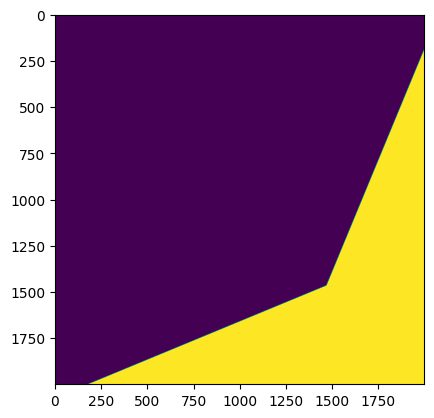

In [50]:
import matplotlib.pyplot as plt

plt.imshow(distance)

In [ ]:
# numba djikstra shortest path one node
# njit with list heapq


pq = [(0, source)]


In [125]:
@numba.njit
def heapsort(iterable):
    # method to seed the type of the list
    ty = iterable[0]
    h = [(3.2, (0,1)) for _ in range(0)]
    for value in iterable:
        heappush(h, (value*.1, (value,value)))
    return [heappop(h) for i in range(len(h))]

heapsort([1, 3, 5, 7, 9, 2, 4, 6, 8, 0])

[(0.0, (0, 0)),
 (0.1, (1, 1)),
 (0.2, (2, 2)),
 (0.30000000000000004, (3, 3)),
 (0.4, (4, 4)),
 (0.5, (5, 5)),
 (0.6000000000000001, (6, 6)),
 (0.7000000000000001, (7, 7)),
 (0.8, (8, 8)),
 (0.9, (9, 9))]